# Gary's Notebook
## Here, I will attempt to learn about ML and CV by doing practical hands-on experiments.

In [114]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image  # in Python3, you need to actually install Pillow. This is an import of Python2.7's PIL
from scipy import signal
from scipy.ndimage import filters

In [115]:
def show_images(image_list, row=1, col=1):
    """
    Helper function. Plot multiple images into a subplot
    @param image_list: list of tuples. First element is a string(name) and second element is the image(PIL Image object)
    """
    for idx, ele in enumerate(image_list):
        plt.subplot(row, col, idx+1)
        plt.title(ele[0])
        plt.imshow(ele[1], cmap="Greys_r")  # need to specifically tell subplot to show grayscaled images
        plt.axis("off")

# #0. Get training images.
### I have a JSON file that contains all a bunch of dog pictures in various format (via Pexel API). The following block of code loads those images into memory

In [116]:
with open("../image_dump/dogs/dump_1.json", "r", encoding="utf-8") as fr:
    j = json.load(fr)

# 250 images. Each image has a width of 180px and height of 130px. Will definitely need to pull more images.
photo_list = list()
for photo in j["photos"]:
    photo_list.append(photo["src"]["small"])

### Now that we have saved the image urls into a list. We use the requests library to fetch those urls and show the image

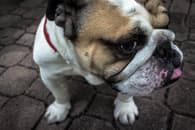

In [117]:
# Pull a random dog image
import random
response = requests.get(photo_list[random.randint(0, len(photo_list)+1)])
im = Image.open(BytesIO(response.content))
im

### Let's use NumPy to show a multi-dimensional representation of above image

In [118]:
np_im_color = np.array(im)
print(np_im_color.shape, np_im_color.dtype)

# Now, compare the matrix against a grayscale image
np_im_gray = np.array(im.convert("L"))
print(np_im_gray.shape, np_im_gray.dtype)

(130, 195, 3) uint8
(130, 195) uint8


# #1. Graylevel transformations
### Ok, cool. So we managed to load an image into a numpy array. What can we do? Well, it turns out that we can do alot. The values in the numpy array represents the intensity of each pixel color. Now, we have a way to control the intensity of each pixel.

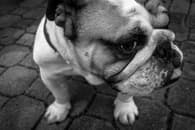

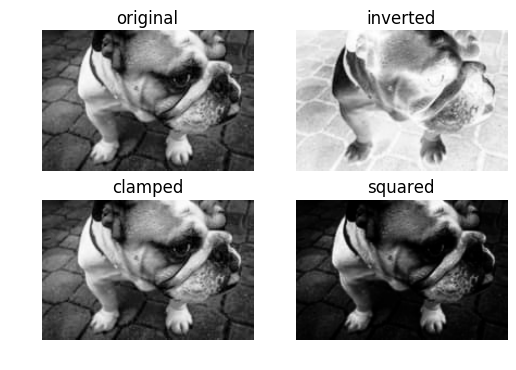

In [119]:
# APPARENTLY Images `fromarray` METHOD ONLY SUPPORTS UINT8 DATATYPES!!! REMEMBER TO TYPECAST THE ELEMENTS
im_1 = 255 - np_im_gray  # inverts the image

im_2 = (100/255)*np_im_gray + 100  # clamps values of each pixel between 100-255
# print(im_2.shape, im_2.dtype)

im_3 = 255.0*(np_im_gray/255.0)**2  # quadratic function, it increases intensity of darker colored pixels

images = [("original", Image.fromarray(np_im_gray)),
          ("inverted", Image.fromarray(im_1)),
          ("clamped", Image.fromarray(np.uint8(im_2))),
          ("squared", Image.fromarray(np.uint8(im_3)))]

show_images(images, 2, 2)
Image.fromarray(np_im_gray)
# Image.fromarray(im_1)

## Another useful graylevel transformation: Histogram equalization.
### This technique tries to equalize the level of intensity of each pixel value. This is usually used to increase image  contrast before processing. (Left) original image and (Right) the darker pixels are much more noticeable

[[ 31.60710059  31.60710059  33.85143984 ...,  56.06698225  65.40189349
   75.21065089]
 [ 29.44544379  31.60710059  33.85143984 ...,  36.14887574  41.43641026
   50.09577909]
 [ 27.58994083  29.44544379  31.60710059 ...,  44.18737673  50.09577909
   59.17830375]
 ..., 
 [ 78.57057199  68.61187377  68.61187377 ...,  78.57057199  78.57057199
   81.63499014]
 [ 53.13877712  47.00852071  50.09577909 ...,  90.534714    78.57057199
   65.40189349]
 [ 53.13877712  47.00852071  50.09577909 ...,  87.68303748  78.57057199
   62.13806706]]


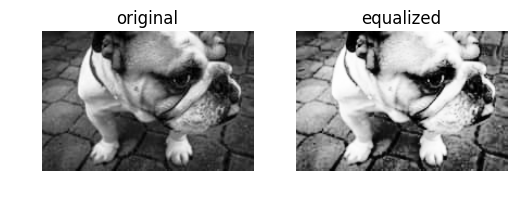

In [120]:
im_hist, bins = np.histogram(np_im_gray.flatten(), 256, normed=True)  # get the histogram of our gray-scaled image
cdf = im_hist.cumsum()  # cumulative distribution function

cdf = 255*cdf/cdf[-1]  # normalize
# cdf.max()
# cdf = (cdf-min(cdf))/(max(cdf)-min(cdf))

im_eqlz = np.interp(np_im_gray.flatten(), bins[:-1], cdf)
im_eqlz = im_eqlz.reshape(np_im_gray.shape)
images = [("original", np_im_gray), ("equalized", im_eqlz)]

show_images(images, 1, 2)
print(im_eqlz)

### Ok, lets see what happens if we apply equalization to a *DARKER* image. Let's use the image with "squared" function applied to it as our original image and apply equalization to it. We would expect the resulting image to be lighter, hence "equalization."

[[ 39.13508528  39.13508528  41.59190115 ...,  64.77102123  74.07169092
   80.89787678]
 [ 36.75882074  39.13508528  41.59190115 ...,  44.17796326  50.29938988
   59.20893932]
 [ 34.46310755  36.75882074  39.13508528 ...,  53.49922652  59.20893932
   67.79122095]
 ..., 
 [ 84.03982457  76.41614913  76.41614913 ...,  84.03982457  84.03982457
   87.32140063]
 [ 61.95338763  56.5376763   59.20893932 ...,  94.47977337  84.03982457
   74.07169092]
 [ 61.95338763  56.5376763   59.20893932 ...,  92.42535778  84.03982457
   70.89316038]]


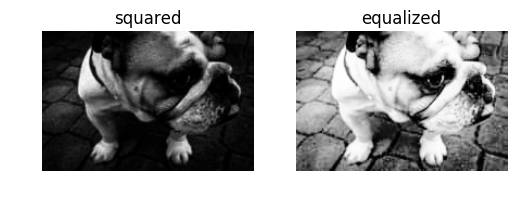

In [121]:
im_hist, bins = np.histogram(im_3.flatten(), 256, normed=True)  # get the histogram of our "squared" image
cdf = im_hist.cumsum()  # cumulative distribution function

cdf = 255*cdf/cdf[-1]  # normalize
# cdf.max()
# cdf = (cdf-min(cdf))/(max(cdf)-min(cdf))

im_eqlz = np.interp(im_3.flatten(), bins[:-1], cdf)
im_eqlz = im_eqlz.reshape(im_3.shape)

images = [("squared", im_3), ("equalized", im_eqlz)]
show_images(images, 1, 2)
print(im_eqlz)  

# Notice that the pixel values for the equalized image are slightly different than from the image above

# *Convolution*: Apparently this is a very important concept in image processing. 
## Convolution, in image processing, is the process of applying a *kernel*, or filter, to every pixel in an image and creating a new resulting image. The size of a kernel is arbitrary, but they are usually 3x3. We convolve images with filters to smooth, sharpen, intensify, or enhance it.
### Let's start with something very simple and play with the identity kernel. If we did this operation crrectly, the convolved image should be exact same as the original image. (We can show this by outputting the image matrix.)

##### See http://www.cs.cornell.edu/courses/cs1114/2013sp/sections/s06_convolution.pdf

In [122]:
id_kernal = np.array([[0,0,0], [0,1,0], [0,0,0]])
h = signal.convolve2d(np_im_gray, id_kernal, mode="same")
np.array_equal(np_im_gray, h)  # verify whether two images are equal

True

### Nice. We can do convolution now. Let's create several other interesting filter. One that blurs and one that sharpens edges. And then lets try using 5x5 filters and compare the output. Go.

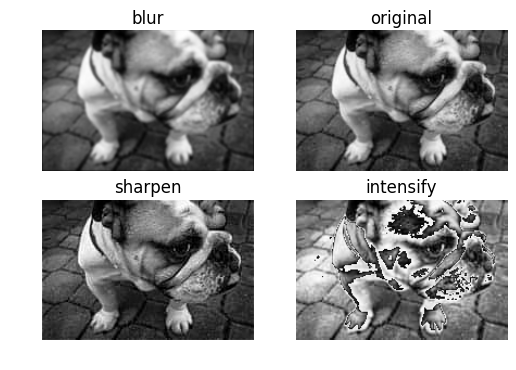

In [123]:
original = Image.fromarray(np_im_gray)
blur_kernel = np.ones((3,3))/9  # 3x3 averaging filter
blur_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, blur_kernel, mode="same")))

intensity_kernel = np.array([[0,0,0], [0,2,0], [0,0,0]])
intensity_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, intensity_kernel, mode="same")))

sharpen_kernel = intensity_kernel - blur_kernel
sharpen_im = Image.fromarray(signal.convolve2d(np_im_gray, sharpen_kernel, mode="same"))
images = [("blur", blur_im), ("original", original), ("sharpen", sharpen_im), ("intensify", intensity_im)]

show_images(images, 2, 2)

### Special note on the averaging filter: Apparently a Guassian filter does a better job. Let's check it out.

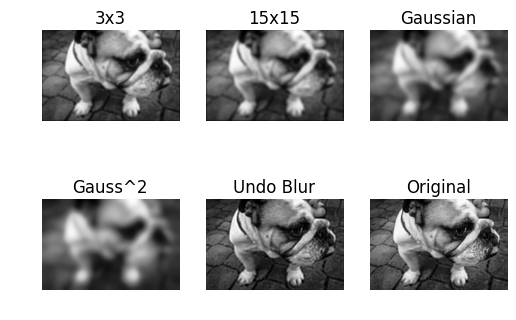

In [124]:
# The second gaussian filter argument is the standard deviation. As STD goes up, the "bluriness" of the image also increases.
# This is due to the inclusion of faraway pixels being calculated into the new convolved image (although pixels further away carry less weight). 
gauss_im = Image.fromarray(filters.gaussian_filter(np_im_gray, 3))

# The convolution operation is associate, so we can keep convolving a filter with itself to amplify its effect.
guass_squared_im = Image.fromarray(filters.gaussian_filter(filters.gaussian_filter(np_im_gray, 3), 3))

# the original blurring filters
blur_kernel_2 = np.ones((5,5))/(5**2)  # try adjusting the filter size and value
blur_im_2 = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, blur_kernel_2, mode="same")))

# let's see if we can "undo" the blurring effects with a sharpen^2 filter
undo_blur_im = Image.fromarray(signal.convolve2d(signal.convolve2d(np.array(blur_im), sharpen_kernel, mode="same"), sharpen_kernel, mode="same"))

show_images([("3x3", blur_im), ("15x15", blur_im_2), ("Gaussian", gauss_im), ("Gauss^2", guass_squared_im), ("Undo Blur", undo_blur_im), ("Original", np_im_gray)], 2, 3)

# Comparison of different sized filters and the Gaussian filter. The Gaussian is clearly more superior. 

## Image derivative.
### An image derivative tells us the pixels' intensity changes across an image. The derivative of an image *I* is described as its gradient: 
$$\nabla I = [I_x I_y]^T$$
### The magnitude of the gradient tells us the intensity change and the angle indicates the direction of the gradient change. Computation of an image is done via convolution with either the *Prewitt* or *Sobel* filters. Apparently the Sobel option is used for edge detection. Let's try both and compare their differences.

### Note: horizontal derivative detects *vertical* edges

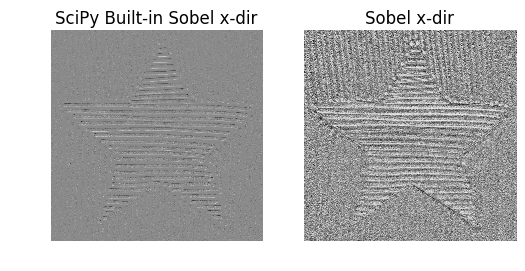

In [132]:
# separate filters in X and Y direction
prewitt_filter_x = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])
prewitt_filter_y = np.array([[-1,-1,-1], [0,0,0], [1,1,1]])

sobel_filter_x = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
sobel_filter_y = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])

prewitt_x_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, prewitt_filter_x, mode="same")))
# sobel_x_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, sobel_filter_x, mode="same")))
sobel_x_im = Image.fromarray(filters.gaussian_filter(np.uint8(signal.convolve2d(np_im_gray, sobel_filter_x, mode="same")), 2.5))

# Let's use a better image to show the effects of the Sobel filter
starsquare_im = np.array(Image.open("../image_dump/starsquare.jpg").convert("L"))
imx = np.zeros(starsquare_im.shape)
filters.sobel(starsquare_im, 1, imx)

imy = np.zeros(starsquare_im.shape)
filters.sobel(starsquare_im, 0, imy)

sobel_x_im = Image.fromarray(filters.gaussian_filter(np.uint8(signal.convolve2d(starsquare_im, sobel_filter_x, mode="same")), 2.5))
sobel_y_im = Image.fromarray(filters.gaussian_filter(np.uint8(signal.convolve2d(starsquare_im, sobel_filter_y, mode="same")), 2.5))

# print(filters.gaussian_filter(np.uint8(signal.convolve2d(np_im_gray, sobel_filter_x, mode="same")), 2.5), "\n\n",filters.sobel(np_im_gray, 1), "\n\n", imx)

show_images([("SciPy Built-in Sobel x-dir", imy), ("Sobel x-dir", sobel_y_im)], 1, 2)

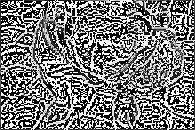

In [126]:
sobel_filter = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
laplacian_filter = np.array([[0,-1,0], [-1,4,-1], [0,-1,0]])  # detects edges in both directions
edge_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, laplacian_filter, mode="same")))
# v_edge_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, sobel_filter, mode="same")))
# h_edge_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, np.rot90(sobel_filter, 2), mode="same")))
edge_im

# #2. Local Descriptors

### I will be learning about methods that detects and locates local image features. Knowing how to extract these features are important when working with panoramas, augmented reality, and computing 3D reconstructions.


## *Harris Corner Detectors*: apparently this is one of the more important algorithms for detecting local features.

In [127]:
imx = np.zeros(np_im_gray.shape)